In [42]:
import geopandas as gpd
import us
import pandas as pd
import libpysal
import matplotlib.pyplot as plt
from helpers import (
    plot_lisa_analysis,
    plot_moran_scatter,
    calculate_moran_i_report,
    map_local_morans,
)

This step of the tutorial focuses on downloading, cleaning, and visualizing county-level geographic data for the contiguous United States (ConUS) using FIPS codes.

- State FIPS Code: A 2-digit code representing a U.S. state or territory.
- County FIPS Code: A 3-digit code representing a county or county-equivalent within a state.

When combined, the State FIPS Code and County FIPS Code form a unique 5-digit identifier for each county in the U.S.

<Axes: >

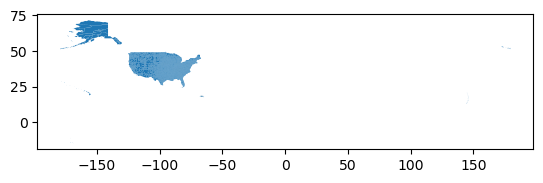

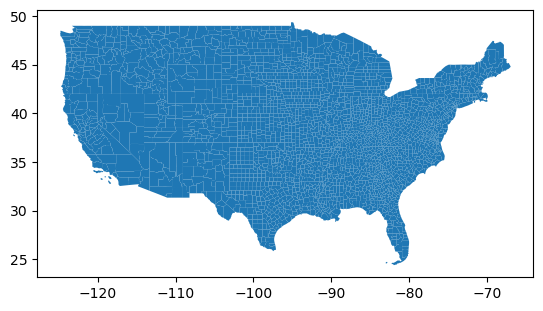

In [43]:
# %% Download and clean county files
# !wget https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip
# !unzip tl_2017_us_county.zip

# %% Read in county file
county = gpd.read_file("tl_2017_us_county.shp")
county.plot()

# %% Limit to ConUS
exclude_states = [
    us.states.GU.fips,
    us.states.AS.fips,
    us.states.MP.fips,
    us.states.PR.fips,
    us.states.AK.fips,
    us.states.HI.fips,
    us.states.VI.fips,
]

county = county[~county["STATEFP"].isin(exclude_states)]
county.plot()

This step processes the HMDA dataset by reading loan data, filtering it to include only approved or purchased loans, and aggregating key metrics such as total loan amount, average loan amount, and median family income. The data is grouped by state, county, loan type, and purchaser type, ensuring clean and structured data for further analysis.

*Note the use of `engine='pyarrow'`* this is a new feature in `pandas` 2.0.0 that allows for faster reading of files. If you are using an older version of `pandas`, you may need to install the `pyarrow` library separately or use the default engine.


In [44]:
# !wget https://files.consumerfinance.gov/hmda-historic-loan-data/hmda_2017_nationwide_first-lien-owner-occupied-1-4-family-records_labels.zip
# !unzip hmda_2017_nationwide_first-lien-owner-occupied-1-4-family-records_labels.zip

# %% Read in loan data
hmda = pd.read_csv(
    "./hmda_2017_nationwide_first-lien-owner-occupied-1-4-family-records_labels.csv",
    engine="pyarrow",

)


# limit to approved or purchased loans
hmda = hmda[(hmda["action_taken"] == 1) | (hmda["action_taken"] == 6)]

# get loans by type
loans = (
    hmda.groupby(
        ["state_code", "county_code", "loan_type_name", "purchaser_type"],
        as_index=False,
    )
    .agg(
        total_loan_amount=("loan_amount_000s", "sum"),
        avg_loan_amount=("loan_amount_000s", "mean"),
        fam_income_med=("hud_median_family_income", "mean"),
    )
    .dropna()
)

loans.head()

,state_code,county_code,loan_type_name,purchaser_type,total_loan_amount,avg_loan_amount,fam_income_med
0,1.0,1.0,Conventional,0,33788.0,154.990826,59700.0
1,1.0,1.0,Conventional,1,37709.0,166.118943,59700.0
2,1.0,1.0,Conventional,3,18750.0,195.312500,59700.0
3,1.0,1.0,Conventional,6,3077.0,181.000000,59700.0
4,1.0,1.0,Conventional,7,2855.0,135.952381,59700.0


This step standardizes FIPS codes by converting state and county codes into zero-padded strings, ensuring they follow the standard 2-digit and 3-digit formats, respectively. 

Additionally, it categorizes the `purchaser_type` variable into three groups: "not_sold," "GSE" (Government-Sponsored Enterprises), and "sold_other," using defined numeric ranges. This prepares the data for further analysis by creating consistent identifiers and meaningful categories.

Categorization of the `purchaser_type` variable is done as follows:
- 'not_sold' is (-.1,0]
- 'GSE' is (0,4]
- 'sold_other' is (4,9]

In [45]:
# standarize FIPS codes
loans["STATEFP"] = loans["state_code"].astype(int).astype(str).str.zfill(2)
loans["COUNTYFP"] = loans["county_code"].astype(int).astype(str).str.zfill(3)

# Set purchaser type to be categorical
loans["sold"] = pd.cut(
    loans["purchaser_type"],
    bins=[-0.1, 0, 4, 9],
    labels=["not_sold", "GSE", "sold_other"],
)

This code isolates loans **sold to Government-Sponsored Enterprises (GSE)** by grouping the loans dataset based on the standardized FIPS codes (`STATEFP` and `COUNTYFP`) and the categorical `sold` column. It then aggregates key metrics for each group, including the total loan amount (`total_loan_amount`), the average loan amount (`avg_loan_amount`), and the average median family income (`fam_income_med`). 


In [46]:
# Isolate loans sold to GSE
loans_sold = (
    loans.groupby(["STATEFP", "COUNTYFP", "sold"])
    .agg(
        total_loan_amount=("total_loan_amount", "sum"),
        avg_loan_amount=("avg_loan_amount", "mean"),
        fam_income_med=("fam_income_med", "mean"),
    )
    .reset_index()
)
loans_sold


/tmp/ipykernel_2221370/3833437383.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loans.groupby(["STATEFP", "COUNTYFP", "sold"])


,STATEFP,COUNTYFP,sold,total_loan_amount,avg_loan_amount,fam_income_med
0,01,001,not_sold,40744.0,154.526873,59700.0
1,01,001,GSE,116935.0,172.215015,59700.0
2,01,001,sold_other,51925.0,162.902722,59700.0
3,01,003,not_sold,254731.0,200.652963,61500.0
4,01,003,GSE,586438.0,186.745559,61500.0
...,...,...,...,...,...,...
51670,78,830,GSE,0.0,NaN,NaN
51671,78,830,sold_other,0.0,NaN,NaN
51672,78,840,not_sold,0.0,NaN,NaN
51673,78,840,GSE,0.0,NaN,NaN


We merge the aggregated data with the county geographic data, ensuring that the resulting dataset contains both geographic and loan-related information. This step is crucial for visualizing the data on a map, as it combines the geographic boundaries with the loan metrics.

Then it calculates the `loan_income_ratio` to assess the relationship between loan amounts and family income.  


Text(0.5, 1.0, 'Loan-to-Income Ratio Loans Sold to GSE')

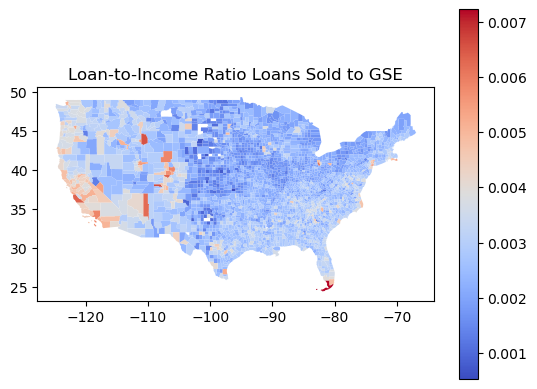

In [47]:

# Merge boundaries / loans
cnt_GSE_loans = pd.merge(
    county,
    loans_sold[loans_sold["sold"] == "GSE"],
    on=["STATEFP", "COUNTYFP"],
    how="left",
    validate="one_to_one",
)

# calculate loan-to-income ratio
cnt_GSE_loans["loan_income_ratio"] = (
    cnt_GSE_loans["avg_loan_amount"] / cnt_GSE_loans["fam_income_med"]
)

# plot loan-to-income ratio
ax = cnt_GSE_loans.plot("loan_income_ratio", cmap="coolwarm", legend=True)
ax.set_title("Loan-to-Income Ratio Loans Sold to GSE")


This goes through the same steps but but for **loans not sold to GSE**.  

Text(0.5, 1.0, 'Loan-to-Income Ratio for Not Sold Loans')

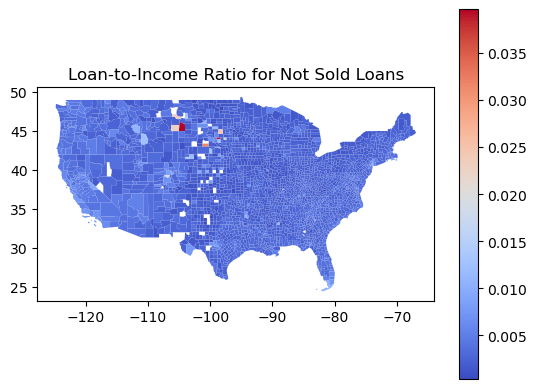

In [48]:
# Isolate loans not sold
cnt_notsold_loans = pd.merge(
    county,
    loans_sold[loans_sold["sold"] == "not_sold"],
    on=["STATEFP", "COUNTYFP"],
    how="left",
    validate="one_to_one",
)
cnt_notsold_loans["loan_income_ratio"] = (
    cnt_notsold_loans["avg_loan_amount"] / cnt_notsold_loans["fam_income_med"]
)
ax = cnt_notsold_loans.plot("loan_income_ratio", cmap="coolwarm", legend=True)
ax.set_title("Loan-to-Income Ratio for Not Sold Loans")


Loans not sold to GSEs are then merged into a common data set `common_loans`. The because we are mergining with more than one geometry column, `geometry_not_sold` is dropped, and the remaining geometry column is renamed and the `geometry` and projection are then reset. 

In [49]:
# Bring loans sold and not sold together into county geodataframe

# Keep only the variables of interest
keep_variables = [
    "STATEFP",
    "COUNTYFP",
    "NAME",
    "geometry",
    "total_loan_amount",
    "avg_loan_amount",
    "fam_income_med",
    "loan_income_ratio",
]


# Merge the two dataframes
common_loans = pd.merge(
    left=cnt_GSE_loans[keep_variables].dropna(subset=["loan_income_ratio"]),
    right=cnt_notsold_loans[keep_variables].dropna(subset=["loan_income_ratio"]),
    on=["STATEFP", "COUNTYFP"],
    how="inner",
    validate="one_to_one",
    suffixes=("_GSE", "_not_sold"),
)
common_loans = common_loans.drop(columns="geometry_not_sold").rename(
    columns={"geometry_GSE": "geometry"}
)
common_loans = common_loans.set_geometry("geometry").to_crs("ESRI:102003")
common_loans.head()
# %% Drop one outlier
# common_loans = common_loans[common_loans["loan_income_ratio_not_sold"] < 0.025]

,STATEFP,COUNTYFP,NAME_GSE,geometry,total_loan_amount_GSE,avg_loan_amount_GSE,fam_income_med_GSE,loan_income_ratio_GSE,NAME_not_sold,total_loan_amount_not_sold,avg_loan_amount_not_sold,fam_income_med_not_sold,loan_income_ratio_not_sold
0,31,039,Cuming,"POLYGON ((-83865.229 505034.281, -83864.472 50...",7899.0,130.210672,62600.0,0.002080,Cuming,753.0,75.000000,62600.0,0.001198
1,53,069,Wahkiakum,"POLYGON ((-2091374.748 1280511.226, -2091836.9...",9919.0,213.080000,62100.0,0.003431,Wahkiakum,3222.0,204.312500,62100.0,0.003290
2,31,109,Lancaster,"POLYGON ((-76027.445 387911.505, -76027.307 38...",429002.0,174.310444,72000.0,0.002421,Lancaster,191344.0,171.473685,72000.0,0.002382
3,31,129,Nuckolls,"POLYGON ((-192145.704 292506.586, -192145.672 ...",1577.0,75.535714,62600.0,0.001207,Nuckolls,7434.0,531.000000,62600.0,0.008482
4,46,099,Minnehaha,"POLYGON ((-90792.712 681979.161, -90774.044 68...",219964.0,178.176350,76800.0,0.002320,Minnehaha,113037.0,173.926505,76800.0,0.002265


Now we can plot both variables of interest, `loan_income_ratio` and `loan_amount`, using the `.plot()` function.

Text(0.5, 1.0, 'Loan-to-Income Ratio not sold')

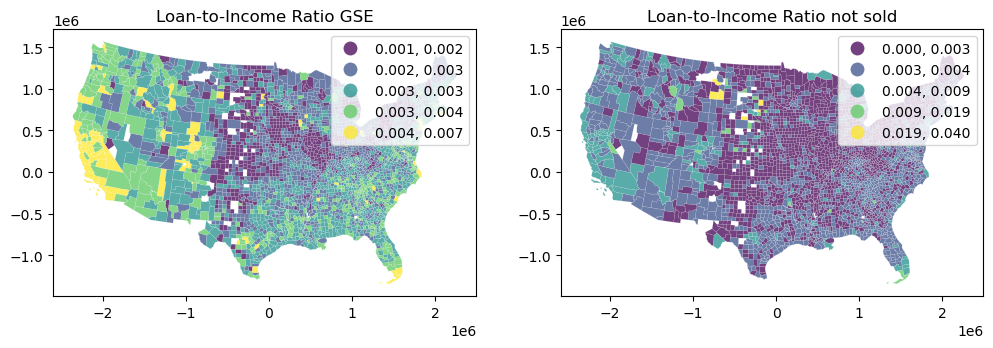

In [50]:
# %% Plot variables of interest
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

common_loans.plot(
    "loan_income_ratio_GSE",
    scheme="NaturalBreaks",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    legend_kwds={"fmt": "{:.3f}"},  # Show 4 decimal places
    ax=ax1,
)
ax1.set_title("Loan-to-Income Ratio GSE")
common_loans.plot(
    "loan_income_ratio_not_sold",
    # cmap="plasma",
    scheme="NaturalBreaks",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    legend_kwds={"fmt": "{:.3f}"},  # Show 4 decimal places
    ax=ax2,
)
ax2.set_title("Loan-to-Income Ratio not sold")

A **weights matrix** is a mathematical representation of spatial relationships between geographic entities, often used in spatial analysis. It defines how areas (e.g., counties) are connected or influence each other, typically based on adjacency or distance. In this tutorial, a **Queen contiguity weights matrix** is created using `libpysal`, where areas are considered neighbors if they share a boundary or corner. 

![alt text](images/queen_contiguity_matrix.png)

The weights are then row-standardized (`w.transform = "R"`) to ensure that the influence of each area sums to 1. This matrix is used to perform spatial autocorrelation analysis, such as calculating Moran's I, which measures the degree of spatial clustering of a variable (e.g., `loan_income_ratio`). It helps identify patterns, such as whether high or low values of the variable cluster geographically.

In [51]:
#  Create the weights matrix from the filtered data
w = libpysal.weights.Queen.from_dataframe(common_loans, use_index=True)
w.transform = "R"  # Row-standardize the weights

Below we can see the resulting neighborhood matrix represented as a graph. The nodes represent the counties, and the edges represent the connections between them based on the Queen contiguity criteria.  

(<Figure size 640x480 with 1 Axes>, <Axes: >)

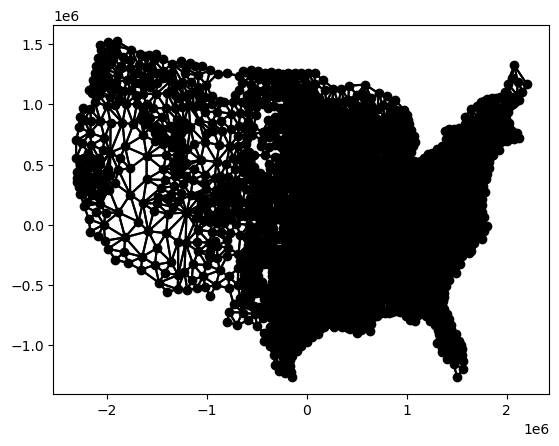

In [52]:
# show the weights
w.plot(common_loans)

> ## Moran's I Tutorial: Spatial Autocorrelation Measure
>Moran's I is a statistical measure used to assess the degree of spatial autocorrelation in a dataset. Spatial autocorrelation refers to the correlation of a variable with itself through space, indicating whether similar values cluster together geographically or are dispersed randomly.
>
> Formula:
> The formula for Moran's I is:
>
> $ I = \frac{N}{W} \cdot \frac{\sum_{i}\sum_{j}w_{ij}(x_i - \bar{x})(x_j - \bar{x})}{\sum_{i}(x_i - \bar{x})^2} $
>
> Where:
> 
> - ($N$): Total number of spatial units (e.g., counties).
> - ($W$): Sum of all spatial weights (($w_{ij}$)).
> - ($w_{ij}$): Spatial weight between units ($i$) and ($j$) (e.g., adjacency or distance-based weights).
> - ($x_i$,$ x_j$): Values of the variable of interest at locations ($i$) and ($j$).
> - ($\bar{x}$): Mean of the variable of interest.
> 
> **Interpretation:**
> - Positive Moran's I: Indicates clustering of similar values (e.g., high values near high values or low values near low values).
> - Negative Moran's I: Indicates dispersion, where dissimilar values are neighbors (e.g., high values near low values).
> - Moran's I ≈ 0: Indicates a random spatial pattern with no significant autocorrelation
> 
> In the context of the tutorial, Moran's I is used to analyze the spatial clustering of variables like loan_income_ratio. A high positive Moran's I would suggest that counties with similar loan-to-income ratios are geographically clustered, while a value near zero would indicate no spatial pattern.
> 
> ### Global Moran’s I – How it works
> Global moran's I like most measures of spatial autocorrelation leverages a **cross-product** between the distance from the mean of  location $(x_i - \bar{x})$, and the difference between the mean and the value of its neighbors $(x_j - \bar{x})$.
> 
> $(x_i - \bar{x})(x_j - \bar{x})$   <-- *this is the cross-product*
> 
> ### Cross-product Examples
> If we assume $\bar{x}$ is = 10, we can plug in some high and low values for `x_i` and `x_j` to see how the cross-product works. 
> 
> | Feature Values | Difference from Mean | Cross-product | Interpretation       | Correlation |
> |----------------|----------------------|----------------|----------------------|-------------|
> | I = 50<br>J = 40 | 40<br>30       | 1200          | High neighbor high   | +           |
> | I = 8<br>J = 6   | –2<br>–4       | 8             | Low neighbor low     | +           |
> | I = 20<br>J = 2  | –10<br>–8      | –80           | High neighbor low    | –           |
> 
> **Take aways:**
> - Positive values imply neighbors are both above or below mean
> - Negative values imply one neighbor above one below mean
> - Larger the deviation, larger the cross-product

In the following block we will calculate the global Moran's I statistic for the `loan_income_ratio` for both `GSE` and `not_sold` loans. This statistic quantifies the degree of spatial autocorrelation in the data, helping to identify whether similar values cluster together or are dispersed across the geographic area.

In [53]:
# %% Moran's I value
# Calculate for GSE loans
mi_gse = calculate_moran_i_report(common_loans, "loan_income_ratio_GSE", w)

# Calculate for not-sold loans
mi_not_sold = calculate_moran_i_report(common_loans, "loan_income_ratio_not_sold", w)

Moran's I Analysis for loan_income_ratio_GSE:
I value: 0.5670
p-value: 0.0000
Interpretation: The data shows moderate positive spatial autocorrelation (clustered) and is statistically significant (p=0.0000).
-------------------------------------------------------
Moran's I Analysis for loan_income_ratio_not_sold:
I value: 0.1920
p-value: 0.0000
Interpretation: The data shows weak positive spatial autocorrelation (slightly clustered) and is statistically significant (p=0.0000).
-------------------------------------------------------


> ## Moran’s I Scatter Plot Tutorial
> Moran’s I is a global measure of spatial autocorrelation — it assesses whether similar attribute values cluster spatially. The **Moran’s I scatter plot** is a graphical diagnostic tool that helps visualize these spatial relationships.
> 
> ### Plot Overview
> 
> This example shows **GSE (Government-Sponsored Enterprise) loans** across spatial units.
> 
> - **X-axis (Attribute):** Standardized value of the variable at each location (e.g., proportion of GSE loans).
> - **Y-axis (Spatial Lag):** Spatially lagged value — the weighted average of neighboring values.
> - **Each Point:** Represents a spatial unit.
> - **Black Trend Line:** Indicates the degree and direction of spatial autocorrelation (the slope is the Moran’s I value).
> 
> ### Interpretation by Quadrant
> 
> The scatter plot is divided into four quadrants:
> 
> | Quadrant        | Description                     | Spatial Pattern     |
> |-----------------|----------------------------------|---------------------|
> | **Upper Right** | High values surrounded by high  | High–High (Red Cluster) |
> | **Lower Left**  | Low values surrounded by low    | Low–Low (Blue Cluster)   |
> | **Upper Left**  | Low values surrounded by high   | Low–High (Orange Outlier)  |
> | **Lower Right** | High values surrounded by low   | High–Low (Light Blue Outlier)  |
> 
> Points in the upper right and lower left indicate **positive spatial autocorrelation** (clustering), while points in the other two quadrants indicate **spatial outliers**.
> 
> ### Take aways:
> 
> - **Positive Moran’s I**: Similar values cluster (as seen in this plot).
> - **Negative Moran’s I**: Dissimilar values are neighbors (more points in opposing quadrants).
> - The **slope** of the trend line is a visual approximation of the **Moran’s I statistic**, which ranges from –1 (perfect dispersion) to +1 (perfect clustering).

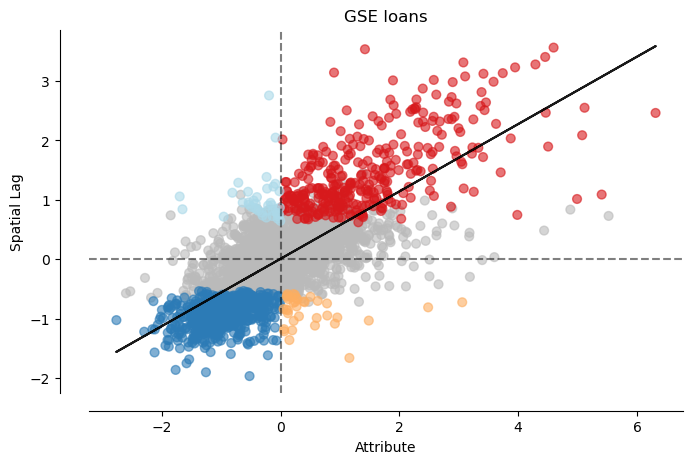

Interpretation of Quadrant Labels:
HH: High-High (positive correlation)
HL: High-Low (negative correlation)
LH: Low-High (negative correlation)
LL: Low-Low (positive correlation)
-------------------------------------------------------
Where values are in XY order - so HL would be high in x-axis, low in y-axis
-------------------------------------------------------


<Axes: title={'center': 'GSE loans'}, xlabel='Attribute', ylabel='Spatial Lag'>

In [54]:
#  Moran's Scatter
plot_moran_scatter(df=common_loans,
    x_name="loan_income_ratio_GSE", w=w , title="GSE loans"
)

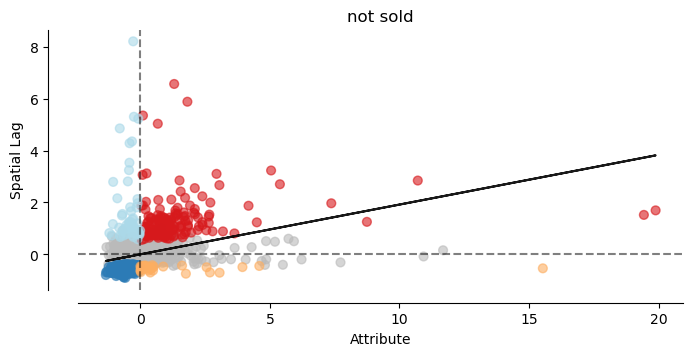

Interpretation of Quadrant Labels:
HH: High-High (positive correlation)
HL: High-Low (negative correlation)
LH: Low-High (negative correlation)
LL: Low-Low (positive correlation)
-------------------------------------------------------
Where values are in XY order - so HL would be high in x-axis, low in y-axis
-------------------------------------------------------


<Axes: title={'center': 'not sold'}, xlabel='Attribute', ylabel='Spatial Lag'>

In [55]:
plot_moran_scatter(
    df=common_loans, x_name="loan_income_ratio_not_sold", w=w, title="not sold"
)

It is often more useful to visualize the results on a map. The following block will plot the results of the Moran's I statistic on a map, using the `plot_lisa_analysis` function. This function creates four maps includings a choloropleth map of the `loan_income_ratio_GSE` and three maps showing the results of the Local Indicators of Spatial Association (LISA) analysis. 

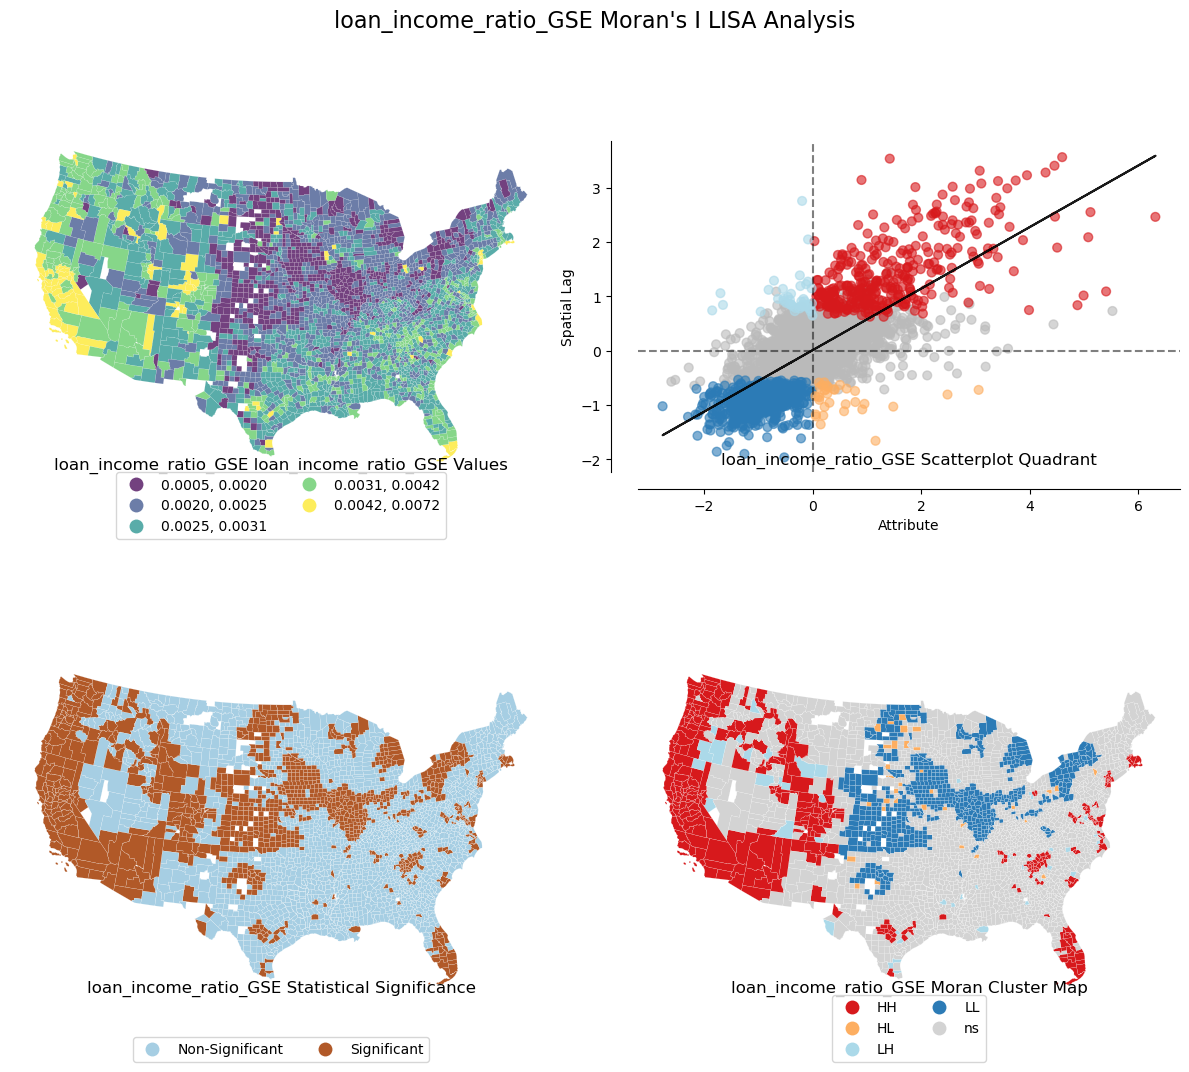


Moran's LISA Analysis interpretation:
1. Values Map: Shows the spatial distribution of loan_income_ratio_GSE values.
2. Quadrant Map: Categorizes each location based on its loan_income_ratio_GSE value and its neighbors:
   - High-High (HH): High values surrounded by high values
   - High-Low (HL): High values surrounded by low values
   - Low-High (LH): Low values surrounded by high values
   - Low-Low (LL): Low values surrounded by low values
3. Scatter Plot: Shows quadrants and statistical significance
4. Cluster Map: Combines quadrant types with statistical significance,
   highlighting only the statistically significant spatial clusters.
-------------------------------------------------------


In [56]:
# %% Lisa PLots - single variable
plot_lisa_analysis(
    df=common_loans,
    x_name="loan_income_ratio_GSE",
    w=w,
    title_prefix="loan_income_ratio_GSE",
    legend_kwds={"fmt": "{:.4f}"}, # Show 4 decimal places
)

> ## Bivariate Moran's I (BiLISA) Tutorial: Spatial Relationship Between Two Variables
> 
> Building on our understanding of **Global Moran’s I**, which measures spatial autocorrelation within a *single*  variable, **Bivariate Moran’s I** explores the **spatial relationship between two different variables**. This is especially useful when you want to know whether high values of one variable tend to be near high (or low) values of another.
> 
> ---
> 
> ### What is Bivariate Moran’s I?
> 
> Bivariate Moran’s I assesses **how the value of variable X at a location relates to the spatial lag of variable Y** (i.e., the average values of Y in neighboring locations). This is particularly useful in identifying **spatial spillover effects**.
> 
> #### Formula:
> 
> $$
I_{XY} = \frac{N}{W} \cdot \frac{\sum_{i} \sum_{j} w_{ij} (x_i - \bar{x})(y_j - \bar{y})}{\sum_i (x_i - \bar{x})^2}
$$
> 
> Where:
> 
> - \(x_i\) is the value of variable X at location \(i\)
> - \(y_j\) is the value of variable Y at neighboring location \(j\)
> - \(\bar{x}, \bar{y}\) are the means of X and Y respectively
> - \(w_{ij}\) is the spatial weight between \(i\) and \(j\)
> 
> ---
> 
> ### Interpretation of Bivariate Moran’s I
> 
> - **Positive I**: High values of X tend to be near high values of Y, or low values of X near low values of Y → *spatial association*.
> - **Negative I**: High values of X are near low values of Y (or vice versa) → *spatial dissimilarity*.
> - **I ≈ 0**: No significant spatial relationship.
> 
> ---
> 
> ## Bivariate LISA (Local Indicators of Spatial Association)
> 
> While Global Bivariate Moran’s I gives an overall measure, **Bivariate LISA** tells us *where* the spatial associations occur.
> 
> ### LISA Quadrants:
> 
> | Quadrant       | Interpretation                      |
> | -------------- | ----------------------------------- |
> | High–High (Q1) | High X with neighbors having high Y |
> | Low–Low (Q3)   | Low X with neighbors having low Y   |
> | High–Low (Q4)  | High X with neighbors having low Y  |
> | Low–High (Q2)  | Low X with neighbors having high Y  |

> These are useful for identifying **hotspots**, **coldspots**, and **outliers** in a bivariate context.
> 
> ---
> 
> ### Example Use Case
> 
> You want to analyze whether **loan-to-income ratios for GSE owned mortgages (X)** are spatially associated with **mortgages that were not sold (Y)**. Bivariate LISA can reveal clusters where:
> 
> - High loan-to-income GSE areas are near high loan-to-income not sold areas (High–High)
> - Low loan-to-income GSE areas areas are near low loan-to-income not sold areas (Low–Low)
> - And where potential spatial mismatches exist (High–Low or Low–High)

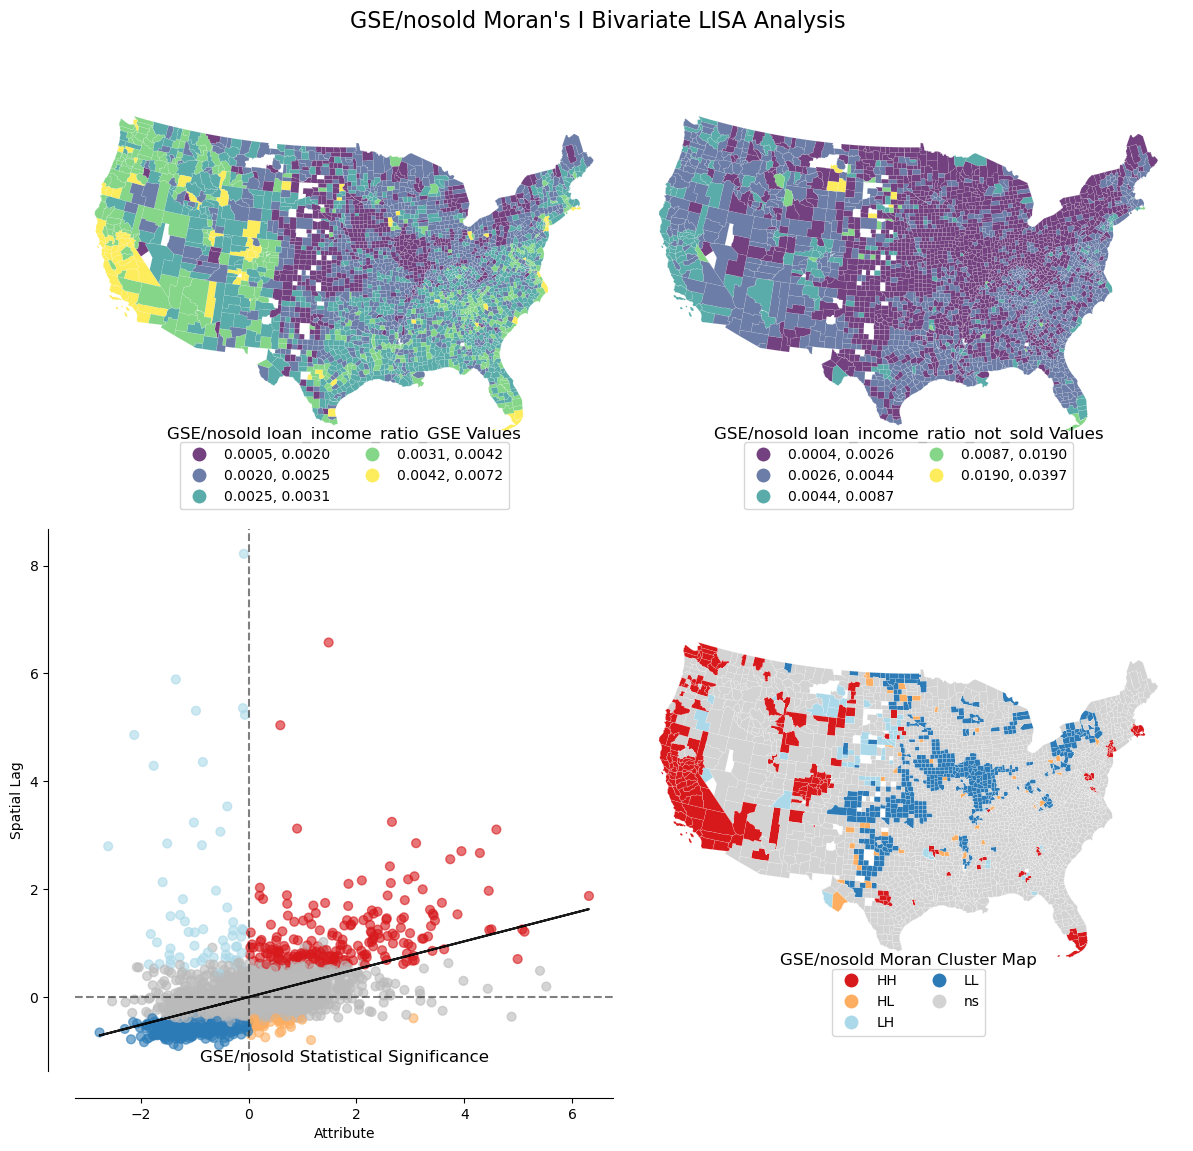


Bivariate Moran's LISA Analysis interpretation:
1. loan_income_ratio_GSE Values Map: Shows the spatial distribution of first variable.
2. loan_income_ratio_not_sold Values Map: Shows the spatial distribution of second variable.
3. Scatter Plot: Shows quadrants and statistical significance
   bivariate spatial relationships (p < 0.05).
4. Cluster Map: Shows significant spatial clusters with the following patterns:
   - High-High (HH): High loan_income_ratio_GSE values surrounded by high loan_income_ratio_not_sold values
   - High-Low (HL): High loan_income_ratio_GSE values surrounded by low loan_income_ratio_not_sold values
   - Low-High (LH): Low loan_income_ratio_GSE values surrounded by high loan_income_ratio_not_sold values
   - Low-Low (LL): Low loan_income_ratio_GSE values surrounded by low loan_income_ratio_not_sold values
-------------------------------------------------------


In [57]:
# %% Lisa Plot - Bivariate
# Calculate local bivariate moran's I

plot_lisa_analysis(
    df=common_loans,
    x_name="loan_income_ratio_GSE",
    y_name="loan_income_ratio_not_sold",
    w=w,
    title_prefix="GSE/nosold",
    legend_kwds={"fmt": "{:.4f}"},
)

Although infrormative, it is hard to evaluate these results on a static map. To help with this, we can use the `map_local_morans` function to create a dynamic map that show the results of the LISA analysis. 

This can be completed for both univariate and bivariate LISA analysis. The following block will show the results of the univariate LISA analysis for `loan_income_ratio_GSE`.

In [ ]:
map_local_morans(
    gdf=common_loans,     
    x_name="loan_income_ratio_GSE",
    w=w,
)

You can also map bivariate LISA analysis results. The following block will show the results of the bivariate LISA analysis for `loan_income_ratio_GSE` and `loan_income_ratio_not_sold`.   

In [ ]:
map_local_morans(
    gdf=common_loans,
    x_name="loan_income_ratio_GSE",
    y_name="loan_income_ratio_not_sold",
    w=w,
)